In [1]:
import os
import PIL
import math
import time
import random
import numpy as np
from PIL import Image
from scipy import ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# CNN model에 필요한 함수 만들기

###  - CNN과 NN의 전반적인 과정이 크게 다르지 않음,  X의 차원이 다르다는 것에 주의하자!

## 1. Preprocessing function(X)

- ** input : 그림, output : 차원이 (이미지 갯수, 가로 픽셀 수, 세로 픽셀 수, 3)** 인 matrix를 만들자!

In [2]:
def make_random_array(length):
    """
    3000개의 그림 file 중 length 개 만큼 비복원 추출하기 위해 만든 함수
    """
    list = []
    ran_num = random.randint(1, 3000)
    for i in range(length):
        while ran_num in list:
            ran_num = random.randint(1, 3000)
        list.append(ran_num)
    return list

In [3]:
def image_to_array(string, index, num_px):
   # change pixel
    image = Image.open(string + str(index) + ".jpg")
    image = image.resize((num_px, num_px), Image.ANTIALIAS)
    # save to matrix
    image = np.array(image)
    return image

In [4]:
def make_X_CNN(num_image, num_px, num_alphabets= 28):
    """
    :param num_image: 각 폴더 내에 있는 3,000개의 image 중 random 추출해 사용할 image의 갯수
    :param num_px: 이미지의 pixel 갯수
    :param num_alphabets: 사용하는 알파벳 갯수
    :return: shape = (num_image * num_alphabets, num_px, num_px, 3)인 matrix
    """
    random.seed(1)
    array = ['A', 'B', 'C','D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                      'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

    # 1. 행렬 초기화(뼈대 만들기)
    images_array = np.zeros((num_image * num_alphabets, num_px, num_px, 3)) # 3 : RGB color

    random_list = make_random_array(num_image)

    # 2. 이미지의 pixel을 변환한 후, 행렬에 이미지 pixel 값 넣기
    image_index = 0
    for i in range(0, num_alphabets):
        os.chdir("C:/Users/엄현호/Desktop/새 폴더/asl-alphabet/asl_alphabet_train/"
                 + str(array[i]))

        for component in random_list:
            image = image_to_array(array[i], component, num_px)
            images_array[image_index] = image
            image_index += 1


    # 3. 행 열 뒤집기, 각 column이 이미지 1개를 나타내도록 해야 모델에 돌릴수 있음!
    images_array = images_array / 255

    return images_array

## 1.1 Preprocessing function (Y)


- 그림들에 label을 부여 (A : 0, B : 1, ... Z : 25, nothing : 26, space : 27)
- 모델에 적용시키기 위해 후에 one-hot-encoding 해줘야함!

In [5]:
def make_Y_CNN(X, num_alphabets = 28):
    """
    :param X: make_X 함수에서 만들어지는 X
    :param num_alphabets: 사용 alphabet 갯수
    :return: a : 0, b : 1, ... z : 25, nothing : 26, space : 27 로 labeling된 행렬
    """
    num_columns = X.shape[0]
    Y = np.zeros((num_columns, 1))
    a = num_columns / (num_alphabets) # 2 : nothing + space
    for j in range(num_alphabets):
        for i in range(int(j*a), int((j+1)*a)):
            Y[i] = j

    return Y

In [6]:
def convert_to_one_hot(Y, C = 28):
    Y = Y.astype(int)
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

## 2. model 돌릴 때 필요한 함수들!

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape = [None, n_y])
    
    return X, Y    

In [9]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.keras.initializers.he_normal(seed= 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.keras.initializers.he_normal(seed= 0))
    
    parameters = {"W1" : W1, "W2" : W2}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.leaky_relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = "SAME")
    A2 = tf.nn.leaky_relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 28, activation_fn = None)
    
    return Z3
    

In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost
    

## CNN model

- ** CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED **

### 층의 개수는 일정하게 하되 filter_size와 같은 세부 hyperparameter들을 바꾸면서 여러 모델을 시험해볼 것

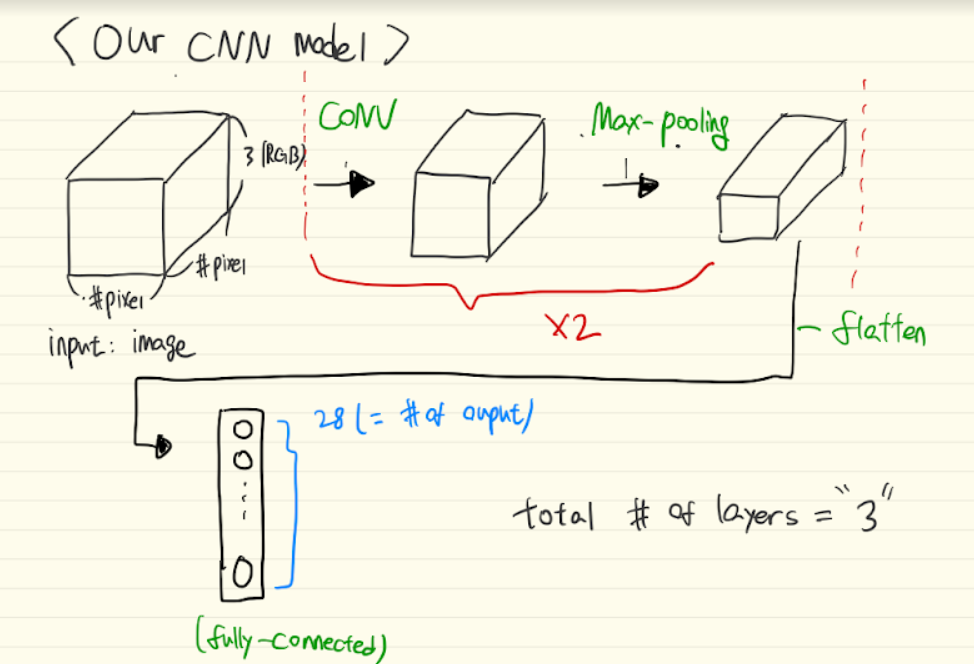





In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y })
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 20 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters   

## 3. model 만들기!


### 1. 이미지들을 행렬로 변환(X)

- X -> row : 그림 갯수 * 픽셀 수 * 픽셀 수 * 3 (RGB color), Column : 알파벳 1개당 이미지 수 * (알파벳 갯수 + 2), 2 : space + nothing인 행렬

- make_X 함수에서 사용할 이미지 갯수, 픽셀 수, 알파벳 갯수(26으로 고정!)를 조정 가능하다!

In [14]:
X = make_X_CNN(num_image = 1000,num_px = 32, num_alphabets = 28) # max_num_alphabets 28


In [15]:
X.shape

(28000, 32, 32, 3)

### 2. 이미지에 labeling하기(Y)
- 신경망의 마지막 층을 softmax로 할 땐(multiple classification), 변수를 one_hot_encoding 해줘야 한다.

In [16]:
Y_not_one_hot = make_Y_CNN(X)
Y_not_one_hot.shape

(28000, 1)

In [17]:
Y = convert_to_one_hot(Y_not_one_hot)
Y.shape

(28000, 28)

### 3) scikit_learn library를 활용해 X,Y를 train, test set으로 분리

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) # train set 80% test set 20%

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (22400, 32, 32, 3)
X_test : (5600, 32, 32, 3)
y_train : (22400, 28)
y_test : (5600, 28)


## 4. CNN model 돌리기!

In [ ]:
# CNN_model 1
# relu, num_epoch = 1000, Xavier Initialization , 그림 50개 32 pixel

Cost after epoch 0: 3.536487
Cost after epoch 20: 2.431842
Cost after epoch 40: 1.986831
Cost after epoch 60: 1.754429
Cost after epoch 80: 1.661106
Cost after epoch 100: 1.567026
Cost after epoch 120: 1.541938
Cost after epoch 140: 1.416852
Cost after epoch 160: 1.375059
Cost after epoch 180: 1.391933
Cost after epoch 200: 1.311249
Cost after epoch 220: 1.289949
Cost after epoch 240: 1.249576
Cost after epoch 260: 1.268669
Cost after epoch 280: 1.229598
Cost after epoch 300: 1.158306
Cost after epoch 320: 1.140302
Cost after epoch 340: 1.167542
Cost after epoch 360: 1.143059
Cost after epoch 380: 1.169391
Cost after epoch 400: 1.105303
Cost after epoch 420: 1.110104
Cost after epoch 440: 1.139267
Cost after epoch 460: 1.075712
Cost after epoch 480: 1.048829
Cost after epoch 500: 1.059432
Cost after epoch 520: 1.133834
Cost after epoch 540: 1.049732
Cost after epoch 560: 1.042766
Cost after epoch 580: 1.149912
Cost after epoch 600: 1.032802
Cost after epoch 620: 1.002994
Cost after epo

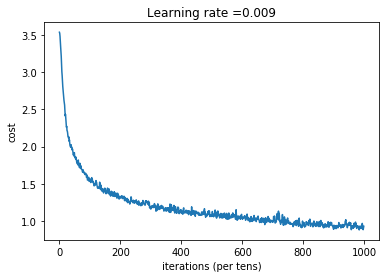

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7178571
Test Accuracy: 0.425
CNN model1 running time: 0.2438228553533554hr


In [103]:
tic = time.time()
_, _, parameters = model(X_train, y_train, X_test, y_test)
toc = time.time()
print("CNN model1 running time: " + str((toc-tic)/3600) + "hr")

In [105]:
# model 2
# model1에서 activate_function : relu -> leaky_relu, num_epoch = 1500, Xavier Initialization, 그림 50개

Cost after epoch 0: 3.543748
Cost after epoch 20: 1.734912
Cost after epoch 40: 1.312591
Cost after epoch 60: 1.063512
Cost after epoch 80: 0.967985
Cost after epoch 100: 0.908660
Cost after epoch 120: 0.796426
Cost after epoch 140: 0.766407
Cost after epoch 160: 0.671246
Cost after epoch 180: 0.653581
Cost after epoch 200: 0.625587
Cost after epoch 220: 0.603586
Cost after epoch 240: 0.616237
Cost after epoch 260: 0.560123
Cost after epoch 280: 0.561515
Cost after epoch 300: 0.492430
Cost after epoch 320: 0.497275
Cost after epoch 340: 0.486958
Cost after epoch 360: 0.618838
Cost after epoch 380: 0.453959
Cost after epoch 400: 0.418319
Cost after epoch 420: 0.464033
Cost after epoch 440: 0.405970
Cost after epoch 460: 0.379131
Cost after epoch 480: 0.448360
Cost after epoch 500: 0.342271
Cost after epoch 520: 0.340847
Cost after epoch 540: 0.367990
Cost after epoch 560: 0.307472
Cost after epoch 580: 0.337087
Cost after epoch 600: 0.340226
Cost after epoch 620: 0.245550
Cost after epo

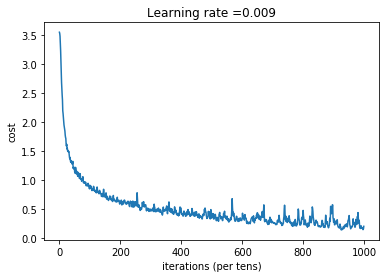

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9392857
Test Accuracy: 0.49642858
CNN model2 running time: 0.27127747661537593hr


In [106]:
tic = time.time()
_, _, parameters2 = model(X_train, y_train, X_test, y_test)
toc = time.time()
print("CNN model2 running time: " + str((toc-tic)/3600) + "hr")

- model 1, 2 : image 갯수를 50개로만 돌려서 test_accuracy가 매우 낮음!


- 활성화 함수를 relu -> leaky_relu로 바꿨을 뿐인데 **Train accuarcy : 71% -> 94%로 25%나 향상! **

In [ ]:
# model 3
# leaky_relu, num_epoch = 1000, he initialziation, 그림 1000개, 32*32 pixels

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 2.619710
Cost after epoch 20: 0.935027
Cost after epoch 40: 0.837069
Cost after epoch 60: 0.771594
Cost after epoch 80: 0.727133
Cost after epoch 100: 0.683621
Cost after epoch 120: 0.648734
Cost after epoch 140: 0.624646
Cost after epoch 160: 0.597830
Cost after epoch 180: 0.596847
Cost after epoch 200: 0.590389
Cost after epoch 220: 0.554093
Cost after epoch 240: 0.556444
Cost after epoch 260: 0.551958
Cost after epoch 280: 0.535191
Cost after epoch 300: 0.522104
Cost after epoch 320: 0.526578
Cost after epoch 340: 0.520478
Cost after epoch 360: 0.519259
Cost after epoch 380: 0.495858
Cost after epoch 400: 0.505732
Cost after epoch 420: 0.498522
Cost after epoch 440: 0.502311
Cost after epoch 460: 0.486231
Cost after epoch 480: 0.491561
Cost after epoch 500: 0.486704
Cost aft

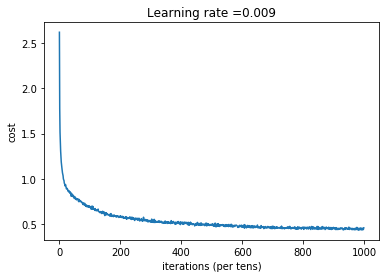

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8459375
Test Accuracy: 0.8282143
CNN model2 running time: 6.829621146321297hr


In [19]:
tic = time.time()
_, _, parameters3 = model(X_train, y_train, X_test, y_test)
toc = time.time()
print("CNN model2 running time: " + str((toc-tic)/3600) + "hr")

## model간 성능 비교!

### model 공통 :  
- 이미지 개수 -> 28 * 1000 = 28000개!
- he 초기화
- leaky_relu 활성화함수



- model 3   (filter_size = 8, 4), 32 pixel ** Train 84.6%, Test : 82.8% ** --> Underfitting!


- model 3.1 (filter_size = 16, 8),32 pixel ** Train 99.1%, Test : 97.4% **
 

- model 3.2 (filter_size = 8, 4), 64 pixel ** Train 99.9%, Test : 58.5% ** --> Overfitting!





## 결론

- CNN model들을 비교했을 때, ** model 3.1이  Train 99.1%, Test 97.4%로 가장 우수! **, 사람의 인식능력과 거의 비슷


- model3.1의 경우 Drop_out 등 다른 overfitting 방지 방법 사용안해도 될 정도!


- NN model보다 전반적으로 성능이 우수한 것을 확인!


### <font color='red'> model3.1을 최종 model로 선정!